In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
import datetime as dt
import community
from shapely.geometry import Polygon

import statsmodels.tsa.api as tsa

import random
import math

import cmocean as cmo



%matplotlib inline

# To do
## Calibration
<li> Visually inspect Beveridge curve to find business cycle </li>
<li> Find the period of the business cycle T </li>

<li> Implement the shock on the calibrated model </li>

# Data Section

## Data acquired:
Occupation transition data between 2016 and 2017  
Employment levels for each occupation for some years  
Swedish beveridge curve from 2004 (aggregate, seasonally and calender adjusted)  
Osborne frey data (matched)

# General
Divide into several notebooks for the github page



In [2]:
# This is where the occupation transition data (as well as occupation code keys) is imported

data = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/swedish_occupation_transitions.csv', sep = ';', index_col = 0)
data.index.name = None
data = data.drop(axis = 1, labels = 'Totalsumma')
data = data.drop(axis = 1, index = 'Totalsumma')
last = data.index[-1]
data = data.rename(index={last: 'NULL'})

# Drop Null and '***' columns
data = data.iloc[0:148, 0:148]
# ['31', '21', '11']

data.drop(labels = ['31', '21', '11'], axis = 0, inplace = True)
data.drop(labels = ['31', '21', '11'], axis = 1, inplace = True)

In [3]:
# This section calculates the adjacency matrix A from the raw data

A = pd.DataFrame(np.zeros(data.shape), columns = data.columns, index = data.index)

for i in range(data.shape[0]):
    total = 0
    for t in range(data.shape[1]):
        if math.isnan(data.iloc[i,t]) != True:
            total += data.iloc[i,t]
        else:
            data.iloc[i, t] = 0

    for j in range(data.shape[1]):
        T = data.iloc[i,j]
        A.iloc[i,j] = (T/total)

A.index = A.index.map(str)
A.columns = A.columns.map(str)

row_nonzeros = np.count_nonzero(A, axis=0)
col_nonzeros = np.count_nonzero(A, axis=1)

for i in range(len(row_nonzeros)):
    if row_nonzeros[i] == col_nonzeros[i] & row_nonzeros[i] == 1:
        print(A.columns[i])

# SSYK 323 and 622 only has selfloops and are not connected to the main component of the graph -> should be removed

data.drop(labels = ['323', '622'], axis = 0, inplace = True)
data.drop(labels = ['323', '622'], axis = 1, inplace = True)

A.drop(labels = ['323', '622'], axis = 0, inplace = True)
A.drop(labels = ['323', '622'], axis = 1, inplace = True)

323
622


In [4]:
# This is where the automation shock data from Frey and Osborne is imported and processed between occupation classification systems

frey_osborne = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/osborne_frey_data.csv', sep = ';', index_col = 0)

SOC_shock = frey_osborne[['Probability', 'SOC code']]
SOC_shock.columns = ['Computerisation Probability', 'soc10']

for i in range(len(SOC_shock['soc10'])):
    SOC_shock.iloc[i,1] = SOC_shock.iloc[i,1][0:2] + SOC_shock.iloc[i,1][3:7]
    #SOC_shock.iloc[i,1] = SOC_shock.iloc[i,1]


SOC_ISCO = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/soc10_isco08.csv', sep = ',')
for i in range(len(SOC_ISCO['isco08'])):
    SOC_ISCO.iloc[i,1] = str(SOC_ISCO.iloc[i,1])
    SOC_ISCO.iloc[i,0] = str(SOC_ISCO.iloc[i,0])
    # if len(SOC_ISCO.iloc[i,1]) == 3:
    #     SOC_ISCO.iloc[i,1] = '0' + SOC_ISCO.iloc[i,1]

ISCO_SSYK = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/nyckel_ssyk2012_isco-08.csv', sep = ';')
ISCO_SSYK = ISCO_SSYK[['SSYK 2012 kod','ISCO-08 ']]
ISCO_SSYK.columns = ['ssyk12', 'isco08']

for i in range(len(ISCO_SSYK['isco08'])):
    ISCO_SSYK.iloc[i,1] = str(ISCO_SSYK.iloc[i,1])
    ISCO_SSYK.iloc[i,0] = str(ISCO_SSYK.iloc[i,0])


# The file above contains many duplicates
ISCO_SSYK.drop_duplicates(inplace=True)

# Below transfers SOC_shock to SSYK_shock
ISCO_shock = pd.merge(SOC_shock, SOC_ISCO, on = 'soc10')

SSYK_shock = pd.merge(ISCO_shock, ISCO_SSYK, on = 'isco08')


# The codes are 4 level need to be 3 level. Only need to change final table (SSYK_shock)
SSYK_shock['ssyk3'] =  [code[0:3] for code in SSYK_shock['ssyk12']]

SSYK3_shock = SSYK_shock[['Computerisation Probability', 'ssyk3']]


SSYK3_shock = SSYK3_shock.groupby(['ssyk3'], as_index=False).mean()


SSYK3 = list(SSYK3_shock['ssyk3'])


G = nx.from_pandas_adjacency(A, create_using = nx.DiGraph)
SSYK3_fromnw = list(G.nodes)
SSYK3_fromnw = [str(node) for node in SSYK3_fromnw]

SSYK_shock.to_csv('/Users/lh/MSc_Thesis/Data_Labour/occupation_shock.csv', sep = ';')

# PRoblem is that certain SOC codes in osborne frey have been abbreviated with 0s. Which makes the matching miss a few rows
# This problem can be fixed

# SOC codes that are not found in the SOC-ISCO translation file
# print(set(SOC_shock['soc10'])-set(SOC_ISCO['soc10']))
# {'292037', '292055', '499799', '291060', '394831', '319799', '292799', '251000', '253999', '151179', '474799', '131078', '452090', '299799', '151150', '151799', '519399', '291111'}

# Focus on '251000', '151150', '291060'
# 291060 solves 221 because 291060 doesnt exist in soc_isco
# 291141, 291151, 291171, 291161 <- 222
# 29-1111 is not used anymore, 29-1141 should be used instead: https://www.onetonline.org/find/quick?s=29-1111

# 231 ssyk: soc_isco översätter till isco 2310 som inte existerar i isco_ssyk nykeln där det istället är 231X. Bör alltså gå att lösa
# 251000: Post-secondary teachers is translated as 2310 SSYK

# SSYK codes not found in ISCO-SSYK translation file
# print(list(set(SSYK3_fromnw) - set(SSYK3)))
# ['221', '21', '11', '222', '231', '31']
# ['21', '11', '31'] are military occupations and we do not have computersiation probabilities for these

# focus on ['221', '222', '231']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [5]:
gdp_gap = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/bnp-gap.csv', sep = ';')
gdp_gap['Qtr'] = pd.to_datetime(gdp_gap.date).dt.quarter
gdp_gap['date'] = [gdp_gap['date'].iloc[i][0:4] + 'Q' + str(gdp_gap['Qtr'].iloc[i]) for i in range(len(gdp_gap['date']))]
gdp_gap['recession'] = [1 if gap <= 0 else 0 for gap in list(gdp_gap['BNP-gap'])]
gdp_gap.rename(columns = {'BNP-gap': 'gdp_gap'}, inplace = True)

In [6]:
# Data for calibrating and setting up the model
employment_SSYK = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/employment_SSYK.csv', sep = ',')
employment_SSYK.rename(columns = {'Yrke (SSYK 2012)':'SSYK'}, inplace = True)
# SSYK code and years as columns

# New calibration data - seasonally adjusted
employment_sa = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/employment_quarterly.csv', sep = ';')
employment_sa['date'] = [str(2000 + employment_sa['year'].iloc[i])+'Q'+str(employment_sa['quarter'].iloc[i]) for i in range(len(employment_sa))]
employment_sa = employment_sa[['date', 'e_sa', 'e_trend']]
employment_sa['e_sa'] = [int(float(string.replace(',','.'))*1000) for string in employment_sa['e_sa']]
employment_sa['e_trend'] = [int(float(string.replace(',','.'))*1000) for string in employment_sa['e_trend']]


unemployment_all = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/unemployment_quarterly.csv', sep = ';')
unemployment_all['date'] = [str(2000 + unemployment_all['year'].iloc[i])+'Q'+str(unemployment_all['quarter'].iloc[i]) for i in range(len(unemployment_all))]
unemployment_sa = unemployment_all[['date', 'u_sa', 'u_trend']]

unemployment_sa['u_sa'] = [float(string.replace(',','.')) for string in unemployment_sa['u_sa']]
unemployment_sa['u_trend'] = [float(string.replace(',','.')) for string in unemployment_sa['u_trend']]

vac_rate_all = pd.read_csv('/Users/lh/MSc_Thesis/Data_Labour/Vacancy Data/sa_2004-2019.csv', sep = ';')

sa_calibration_data = pd.merge(unemployment_sa, vac_rate_all[['date', 'sa_vac', 'na_vac']], on ='date')
sa_calibration_data = pd.merge(sa_calibration_data, employment_sa, on = 'date')
sa_calibration_data = pd.merge(sa_calibration_data, gdp_gap[['date', 'recession']], on = 'date')

sa_calibration_data['sa_vac_rate'] = sa_calibration_data['sa_vac']*100/(sa_calibration_data['e_trend']+sa_calibration_data['sa_vac'])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# Data visualisation section
The following cells include code used to visualise the raw data, this includes:  
Network Visualisation  
Beveridge Curve

## Visualisation to do
Visualise the network using occupation classification (almost done - legend needs to be fixed)
Draw the beveridge curve for all years

In [7]:
# This sets up the visualization of the network
## The size of the nodes is proportional to the amount of workers who stayed in their proffesion between 2016 and 2017

def softmax(A,k=1.0):
    """
    Calculates the softmax of a distribution, modulated by the precision term, k
    Used here to adjust the size of the nodes
    """
    A = np.array(A) if not isinstance(A, np.ndarray) else A
    A = A*k
    maxA = A.max()
    A = A-maxA
    A = np.exp(A)
    return A/np.sum(A)

# Create the graph G from the adjeceny matrix
G = nx.from_pandas_adjacency(A, create_using = nx.DiGraph)

# List of all the occupation codes
occupations = list(G.nodes)

# Dictionaries holding the first and second levels of the SSYK code respectively
first_level = {name:name[0] for name in occupations}
second_level = {name:name[0:1] for name in occupations}

# The amount of workers who stayed in their proffession
remain_workers = np.diag(data)

# Make it into a dict 
remain_dict = dict(zip(list(G.nodes), remain_workers))

# Calculate the size of each node
ns = softmax(0.7*np.log2(10000+np.array(list(remain_dict.values()))))*15000

# Give the network the attributes used for visualisation
nx.set_node_attributes(G, first_level, 'SSYK1')
nx.set_node_attributes(G, second_level, 'SSYK2')
nx.set_node_attributes(G, remain_dict, 'remained_workers')

# Ten colors used for visualisation
cols = ["#69b243", "#ad5ec7", "#bfaf48", "#7778c8", "#c87f41", "#4bafd0", "#ce4a3d", "#55a977", "#cd4b8f", "#70742e", "#c36a7c"]

# Get all the unique first level codes
vals = list(set(val for val in first_level.values()))

# Make a dict that stores the color each node should get based on their first level
col_dict = {}
for i in range(len(vals)):
    col_dict[vals[i]] = cols[i]

# Make a list that contains the color of every node
node_col_list = [col_dict[val] for val in first_level.values()]
edge_col_list = [col_dict[val[0]] for val,_ in G.edges()]

# Make a list that contains the weight for each link
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
weights = softmax(0.7*np.log2(1000+np.array(weights)))*1500



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


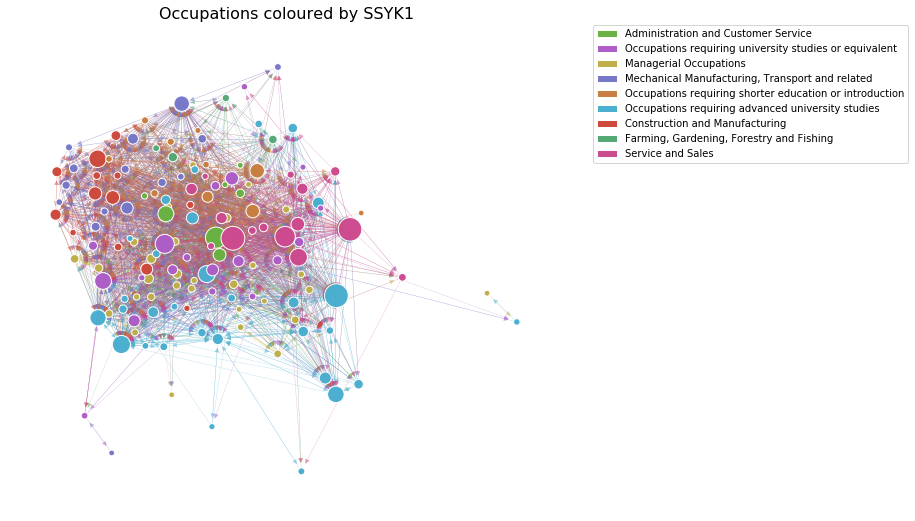

In [8]:
# This section visualises the network where nodes are colored by their first level code and the size correspond to the number of workers 
# who stayed in their proffession


fig, ax = plt.subplots(1,1,figsize=(10,9))

legend_elements = []

occ_dict = {'1': 'Chefsyrken', '2': 'Yrken med krav på fördjupad högskolekompetens', '3':'Yrken med krav på högskolekompetens eller motsvarande', '4': 'Yrken inom administration och kundtjänst', '5':'Service-, omsorgs- och försäljningsyrken', '6': 'Yrken inom lantbruk, trädgård, skogsbruk och fiske', '7':'Yrken inom byggverksamhet och tillverkning', '8': 'Yrken inom maskinell tillverkning och transport m.m.', '9':'Yrken med krav på kortare utbildning eller introduktion'}


en_occ_dict = {'1': 'Managerial Occupations', '2': 'Occupations requiring advanced university studies', '3':'Occupations requiring university studies or equivalent', '4': 'Administration and Customer Service', '5':'Service and Sales', '6': 'Farming, Gardening, Forestry and Fishing', '7':'Construction and Manufacturing', '8': 'Mechanical Manufacturing, Transport and related', '9':'Occupations requiring shorter education or introduction'}

for level, col in col_dict.items():
    legend_elements.append(Patch(facecolor = col, edgecolor='w', label=en_occ_dict[level]))

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, with_labels = True, node_color=node_col_list, node_size = ns, alpha=0.99, edgecolors='w', ax = ax)

nx.draw_networkx_edges(G, pos, edge_color=edge_col_list, width=weights, alpha=0.5, ax=ax)

ax.set_axis_off()

ax.set_title("Occupations coloured by SSYK1", fontsize=16)


# Create the figure

plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

#plt.savefig('e_coli.png', dpi=425, bbox_inches='tight')
plt.show()

# Two occupations only have a self-loop

In [9]:
of_data = SSYK_shock.groupby(by = ['ssyk3'], axis = 0).mean()
of_data = of_data.to_dict()['Computerisation Probability']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


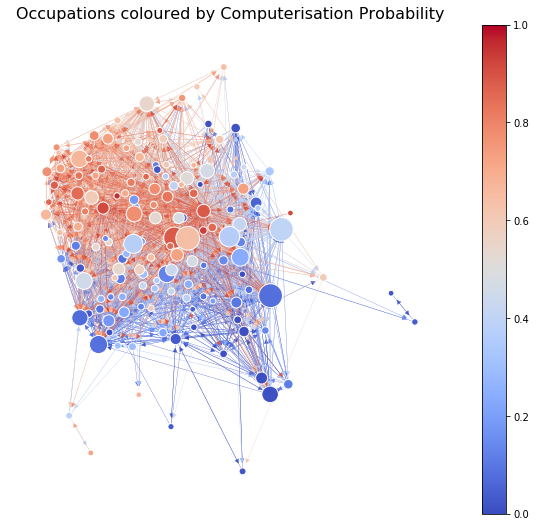

In [10]:
# Visualisation of Frey and Osborne data
# This section visualises the network where nodes are colored by their first level code and the size correspond to the number of workers 
# who stayed in their proffession
fig, ax = plt.subplots(1,1,figsize=(10,9))

node_colors = [plt.cm.coolwarm(of_data[occ]) for occ in G.nodes]
edge_colors = [plt.cm.coolwarm(of_data[occ]) for occ,_ in G.edges]

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(0,1))
sm._A = []
plt.colorbar(sm)

nx.draw_networkx_nodes(G, pos, with_labels = True, node_color=node_colors, node_size = ns, alpha=0.99, edgecolors='w', ax = ax)

nx.draw_networkx_edges(G, pos, edge_color= edge_colors, width=weights, alpha=0.5, ax=ax)

ax.set_axis_off()

ax.set_title("Occupations coloured by Computerisation Probability", fontsize=16)

#plt.savefig('e_coli.png', dpi=425, bbox_inches='tight')
plt.show()

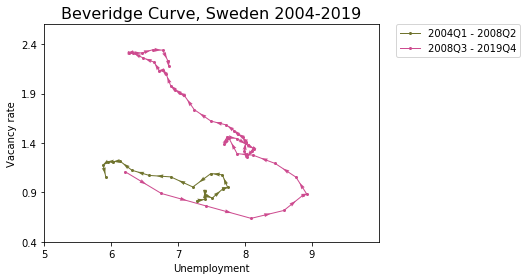

In [14]:
plot_ls = []
plot_dict = {'start': '', 'end': '', 'u': [], 'vac': []}

prev_status = sa_calibration_data['recession'].iloc[0]
plot_dict['start'] = sa_calibration_data['date'].iloc[0]
status_change = 0
for i in range(len(sa_calibration_data)):
    status = sa_calibration_data['recession'].iloc[i]
    if status == prev_status:
        plot_dict['u'].append(sa_calibration_data['u_trend'].iloc[i])
        plot_dict['vac'].append(sa_calibration_data['sa_vac_rate'].iloc[i])
    else:
        status_change += 1
        if status_change == 3:
            plot_dict['end'] = sa_calibration_data['date'].iloc[i-1]
            plot_ls.append(plot_dict)
            plot_dict = {'start': sa_calibration_data['date'].iloc[i], 'end': '', 'u': [sa_calibration_data['u_trend'].iloc[i]], 'vac': [sa_calibration_data['sa_vac_rate'].iloc[i]]}
            status_change = 0
        else:
            plot_dict['u'].append(sa_calibration_data['u_trend'].iloc[i])
            plot_dict['vac'].append(sa_calibration_data['sa_vac_rate'].iloc[i])
    prev_status = status

plot_dict['end'] = sa_calibration_data['date'].iloc[-1]
plot_ls.append(plot_dict)


x = sa_calibration_data['u_trend'].values
y = sa_calibration_data['sa_vac_rate'].values



fig, ax = plt.subplots()
cols = ["#69b243", "#ad5ec7", "#bfaf48", "#7778c8", "#c87f41", "#4bafd0", "#ce4a3d", "#55a977", "#cd4b8f", "#70742e"]

legend_elements = []

for data in plot_ls:
    col = cols.pop()
    plt.plot(data['u'], data['vac'], color = col, ls = '-', marker = 'o', linewidth = 1, markersize = 2, label = data['start']+' - '+data['end'])
    x = data['u']
    y = data['vac']
    u = np.diff(x)
    v = np.diff(y)
    pos_x = x[:-1] + u/2
    pos_y = y[:-1] + v/2
    norm = np.sqrt(u**2+v**2) 
    ax.quiver(pos_x, pos_y, u/norm, v/norm, angles="xy", zorder=5, pivot="mid", scale = 50, color = col)
    #legend_elements.append(Patch(facecolor = col, edgecolor='w', label=data['start']+' - '+data['end']))
    # plt.annotate(data['start'], # this is the text
    #              (data['u'][0],data['vac'][0]), # this is the point to label
    #              textcoords="offset points", # how to position the text
    #              xytext=(0,-10), # distance from text to points (x,y)
    #              ha='center')
    # plt.annotate(data['end'], # this is the text
    #              (data['u'][-1],data['vac'][-1]), # this is the point to label
    #              textcoords="offset points", # how to position the text
    #              xytext=(0,15), # distance from text to points (x,y)
    #              ha='center')



# ax.axis('equal')
ax_bounds = [5, 10, 0.4, 2.6]
ax.axis(ax_bounds)
ax.xaxis.set_ticks(np.arange(ax_bounds[0], ax_bounds[1], 1))
ax.yaxis.set_ticks(np.arange(ax_bounds[2], ax_bounds[3], 0.5))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
ax.set_title("Beveridge Curve, Sweden 2004-2019", fontsize=16)
ax.set_xlabel('Unemployment')
ax.set_ylabel('Vacancy rate')
plt.show()

# Model Section
The follwowing cells include all the funcitons used in the simulation  
Most code is commented and all functions have a custom description

## Model to do
Fix inevitable bugs since the code has not been run with actual data  
Comment all code

In [35]:
# setup network
def set_attributes(G, data):
    '''
    Initialises the node attributes of the occupational mobility network.
    Parameters:
    -----------
    G (nx.graph): The occupational mobility network
    data (?): Data used to specify attribute values
    
    setting up data will have the following form:
    data (pd.DataFrame): Columns contain values for the attributes and rows are occupations

    The attributes are:
    employed (int): Number of employees in the occupation
    unemplyed (int): Number of unemployed in the occupation
    vacancies (int): Number of vacancies in the occupation
    applications (list): List where the elements are the name of the occupation where the application is coming from
    target_demand (int): The target demand of the occupation (exogenous and used for automation shock)
    risk_factor (float): A value between 0 and 1 indicating the risk of a proffession (could be automation or corona or whatever)

    Note that the current demand is implicit (=employed + vacancies)
    '''
    # Make dictionaries
    attributes = data.to_dict()

    # Add some variables
    # attributes['target_demand']
    
    # Set attrbutes
    for key, value in attributes.items():

        nx.set_node_attributes(G, value, str(key))

def make_vacancies(G, delta_ny, gamma_ny):
    '''
    Each occupation has a probability of making vacancies each time step that depends on the difference between
    current demand and target demand as well as an exogenous probability 

    Parameters:
    -----------
    G (nx.graph): The occupational mobility network
    other parameters
    '''
    # The attributes we need to calculate new vacancies
    vac_dict = nx.get_node_attributes(G, 'vacancies')
    emp_dict = nx.get_node_attributes(G, 'employed')
    td_dict = nx.get_node_attributes(G, 'target_demand')

    # loop through all the occupations and create vacancies as described in the paper
    for occupation in vac_dict.keys():
        # The occupation specificattribute values
        target_demand = td_dict[occupation]
        employed = emp_dict[occupation]
        current_demand = vac_dict[occupation] + employed
        

        # Calculate the probability of creating new vacancies (equation 10)
        demand_diff = max(0, target_demand - current_demand)

        # Zero Steady State rule
        if employed == vac_dict[occupation] == 0 and target_demand > 0:
            vacancies += 1
        else:
            if demand_diff == 0 or employed == 0:
                alpha_ny = 0
            else:
                alpha_ny = gamma_ny*demand_diff/employed

            p_ny = delta_ny + alpha_ny - delta_ny*alpha_ny

            # Expected number of new vacancies - wrong
            # new_vacancies = round(p_ny*employed
            new_vacancies = np.random.binomial(employed, p_ny)
            # Add the new vacancies to total number of vacancies
            vac_dict[occupation] += new_vacancies

    nx.set_node_attributes(G, vac_dict, 'vacancies')


def separate_workers(G, delta_u, gamma_u):
    '''
    Each occupation has a probability of seperating workers each time step that depends on the difference between
    current demand and target demand as well as an exogenous probability 

    Parameters:
    -----------
    G (nx.graph): The occupational mobility network
    other parameters
    '''

    # The attributes we need to calculate number of seperated workers
    unemp_dict = nx.get_node_attributes(G, 'unemployed')
    emp_dict = nx.get_node_attributes(G, 'employed')
    td_dict = nx.get_node_attributes(G, 'target_demand')
    vac_dict = nx.get_node_attributes(G, 'vacancies')

    # loop through all the occupations and seperate workers as described in the paper
    for occupation in unemp_dict.keys():
        # The occupation specificattribute values
        target_demand = td_dict[occupation]
        employed = emp_dict[occupation]
        vacancies = vac_dict[occupation]

        current_demand = vacancies + employed

        # Calculate the probability of creating new vacancies (equation 9)
        demand_diff = max(0, current_demand - target_demand)
        if demand_diff == 0 or employed == 0:
            alpha_u = 0
        else:
            alpha_u = gamma_u*demand_diff/employed
        # probability calculation (equation 11)
        p_u =  delta_u + alpha_u - delta_u*alpha_u
        

        # This is the expected number of seperated workers - WRONG!!!
        # separated = round(p_u*unemployed)
        separated = np.random.binomial(employed, p_u)

        unemp_dict[occupation] += separated
        emp_dict[occupation] -= separated
    nx.set_node_attributes(G, unemp_dict, 'unemployed')
    nx.set_node_attributes(G, emp_dict, 'employed')

def make_applications(G):
    '''
    Each unemployed worker send out an application to a neighbouring occupation proportional to the edge weight
    between the occupations

    Parameters:
    -----------
    G (nx.graph): The occupational mobility network
    '''
    # loop through every occupation and every unemployed person in the occupation and add applications in the 
    # applications attribute of the occupation that the worker applies to
    app_dict = nx.get_node_attributes(G, 'applications')
    unem_dict = nx.get_node_attributes(G, 'unemployed')
    vac_dict = nx.get_node_attributes(G, 'vacancies')

    A_dict = nx.get_edge_attributes(G, 'weight')

    for occupation in app_dict:
        unemployed = unem_dict[occupation]
        neighbors = [n for n in G.neighbors(occupation)]

        # Calculate probabilities (equation 7)
        vac_A_list = [vac_dict[n]* A_dict[(occupation, n)] for n in neighbors]
        vac_A_sum = sum(vac_A_list)
        if vac_A_sum == 0:
            continue
        p_list = [vac_A/vac_A_sum for vac_A in vac_A_list]

        # Each unemployed person chooses an occupation to apply to
        for _ in range(unemployed):
            # Choice is weighted by probabilities calculated above
            apply_to = np.random.choice(neighbors, p = p_list)
            # Make the application
            app_dict[apply_to].append(occupation)
    nx.set_node_attributes(G, app_dict, 'applications')


def handle_applications(G):
    '''
    Randomly accept N applications in the application attrbute where N is the number of vacancies in the occupation

    Parameters:
    -----------
    G (nx.graph): The occupational mobility network
    '''
    # The attributes we need
    app_dict = nx.get_node_attributes(G, 'applications')
    vac_dict = nx.get_node_attributes(G, 'vacancies')
    emp_dict = nx.get_node_attributes(G, 'employed')
    unemp_dict = nx.get_node_attributes(G, 'unemployed')

    # loop through all the occupations and try to accept the same number of applications as there are vacancies
    for occupation in app_dict:
        applications = app_dict[occupation]
        vacancies = vac_dict[occupation]

        filled_vacancies = 0
        for j in range(vacancies):
            if len(applications) == 0:
                # if vacancies > len(applications) not all vacancies are filled
                break
            # A random application is chosen (and removed from the list of applications)
            accepted = applications.pop(random.randrange(len(applications)))

            # Increase the amount of employed people in the occupation by the number of filled vacancies
            emp_dict[occupation] += 1

            # Decrease the amount of unemployed people in the occupations where applications were accepted from
            unemp_dict[accepted] -= 1
            # Number of filled vacancies
            filled_vacancies = j + 1
    
        # Decrease the amount of vacancies in the occupation
        vac_dict[occupation] = vacancies - filled_vacancies
        # Update the applications list
        app_dict[occupation] = applications
    
    # Update the network node attributes
    nx.set_node_attributes(G, app_dict, 'applications')
    nx.set_node_attributes(G, vac_dict, 'vacancies')
    nx.set_node_attributes(G, emp_dict, 'employed')
    nx.set_node_attributes(G, unemp_dict, 'unemployed')

def update_target_demand(G, demand_0, t, T, a):
    '''
    function that updates the target demand. Used for calibrating the the model paramters

    Parameters:
    -----------
    G (nx.Graph): The occupational mobility network
    demand_0 (int): Initial demand
    t (int): Timestep of simulation
    T (float): The duration of a business cycle
    a (float): the amplitude of the business cycle sin wave
    '''

    target_demand = {}
    for node in G.nodes():
        target_demand[node] = round(demand_0[node]*(1 + a*np.sin(t/(2*np.pi*T))))

    nx.set_node_attributes(G, target_demand, 'target_demand')


def shock(G, demand_0, final_demand, t, t_0, k):
    '''
    function that implements the labour demand shock

    Parameters:
    -----------
    G (nx.Graph): The occupational mobility network
    demand_0 (int): Initial demand
    t (int): Timestep of simulation
    t_0 (int): Midpoint of shock (where sigmoid goes from exponential increase to exponential decrease)
    k (float): 

    '''

    demand_shock = {}
    target_demand = {}

    for key in employed.keys():
        demand_shock[key] = (final_demand[key] - demand_0[key])/(1 + np.exp(k*(t-t_0)))
        target_demand[key] = demand_0[key] + demand_shock[key]

    nx.set_node_attributes(G, target_demand, 'target demand')


def calibration_calculation(empirical_data, model_data, A_e, fast = True):
    '''
    This is the function to be minimised during calibration.abs

    Parameters:
    empirical_data (dict): timeseries of vacancies and unemployment
    model_data (dict): timeseries of vacancies and unemployment
    '''


    m_vacancies = [sum(model_data['vacancies'][i].values()) for i in range(len(model_data['vacancies']))]
    m_employed = [sum(model_data['employment'][i].values()) for i in range(len(model_data['employment']))]

    m_vac_rate = [m_vacancies[i]*100/(m_vacancies[i] + m_employed[i]) for i in range(len(m_employed))]

    m_unemployed = [sum(model_data['unemployment'][i].values()) for i in range(len(model_data['unemployment']))]
    m_unemployed = [u*100/(m_employed[i]+ u) for i, u in enumerate(m_unemployed)]

    m_seq = [(u, m_vac_rate[i]) for i, u in enumerate(m_unemployed)]
   

    fig, ax = plt.subplots()
    plt.plot(m_unemployed, m_vac_rate, ls = '-', marker = 'o', linewidth = 1, markersize = 2)
    plt.show()
    if fast == False:
        fig, ax = plt.subplots()
        plt.plot(e_unemployed, e_vac_rate, ls = '-', marker = 'o', linewidth = 1, markersize = 2)
        plt.show()

    if Polygon(m_seq).is_valid == True:
        A_m = Polygon(m_seq)
    else:
        print('A_m is not valid')
        return {'cost':'N/A', 'intersection':'N/A', 'union':'N/A'}
    try:
        A_m.union(A_e).is_valid
        union_area = A_m.union(A_e).area
    except TopologicalError:
        print('union is not found')
        union_area = 'N/A'
        cost = 'N/A'
    try:
        A_m.intersection(A_e).is_valid
        intersection_area = A_m.intersection(A_e).area
    except TopologicalError:
        print('intersection is not found')
        intersection_area = 'N/A'
        cost = 'N/A'
    if A_m.union(A_e).is_valid == True and A_m.intersection(A_e).is_valid == True:
        cost = intersection_area/union_area
        print('Union area: ', union_area, 'Intersection_area: ', intersection_area)

        
            

    # union_area = union.area
    # intersection_area = intersection.area 

    return {'cost':cost, 'intersection':intersection_area, 'union':union_area}


def simulation(G, years, timestep, delta_u, gamma_u, delta_ny, gamma_ny, empirical_data, t_0, k, L, avg_hours_0, a, T, shock_start, attributes, calibration_output = False):
    '''
    Set attribute data of occupational mobility netowrk and carry out the simulation for a specified number of timesteps

    Parameters:
    -----------
    G (nx.Graph): The occupational mobility network
    data (pd.DataFrame): DataFrame containing data
    years (int): Number of years for the simulation
    timestep (float): size of each timestep in terms of weeks
    delta_u (float): probability of spontanous seperation
    delta_ny (float): probability of spontanously opneing vacancy
    gamma_u (float): speed of unemployed adjustment towards target demand
    gamma_ny (float): speed of vacancy adjustment towards target demand
    '''

    #set_attributes(G, data)
    # This needs to be put into the network (used as starting point)

    for key, value in attributes.items():
        nx.set_node_attributes(G, value, str(key))

    timesteps = round(years*52/timestep)
    T_steps = round(T*52/timestep)

    vacancies = nx.get_node_attributes(G, 'vacancies')
    employed = nx.get_node_attributes(G, 'employed')

    demand_0 = {}

    for key in vacancies.keys():
        demand_0[key] = vacancies[key] + employed[key] 

    vac_data = []
    emp_data = []
    unemp_data = []

    # Variables to calculate the post shock demand
    risk_factor = nx.get_node_attributes(G, 'comp_prob')
    average_hours_worked_0 = avg_hours_0
    

    final_hours_worked = {}

    for occupation in risk_factor.keys():
        final_hours_worked[occupation] = average_hours_worked_0*employed[occupation]*(1-risk_factor[occupation])

    final_average_hours_worked = sum(final_hours_worked.values())/L

    # Post shock demand
    final_demand = {occupation:hours/final_average_hours_worked for occupation, hours in final_hours_worked.items()}

    for t in range(timesteps):
        handle_applications(G)
        make_applications(G)
        make_vacancies(G, delta_ny, gamma_ny)
        separate_workers(G, delta_u, gamma_u)

        # order should be checked and changed
        # if t > shock_start:
        #    shock(G, demand_0, final_demand, t, t_0, k)

        vac_data.append(nx.get_node_attributes(G, 'vacancies'))
        unemp_data.append(nx.get_node_attributes(G, 'unemployed'))
        emp_data.append(nx.get_node_attributes(G, 'employed'))

        update_target_demand(G, demand_0, t, T_steps, a)
    

    model_data = {'vacancies': vac_data, 'unemployment': unemp_data, 'employment':emp_data}
    print('a: ', a, 'delta_u', delta_u, 'delta_ny', delta_ny)
    cost = calibration_calculation(empirical_data, model_data)

    vac_data = pd.DataFrame(vac_data)
    unemp_data = pd.DataFrame(unemp_data)
    emp_data = pd.DataFrame(emp_data)

    if calibration_output == True:
        return cost
    else:
        return {'vacancy_data': vac_data, 'unemployment_data': unemp_data, 'employment_data': emp_data, 'cost': cost}

def deterministic_simulation(G, years, timestep, delta_u, gamma_u, delta_ny, gamma_ny, empirical_data, t_0, k, L, avg_hours_0, a, T, shock_start, attributes, calibration_output = False):
    #set_attributes(G, data)
    # This needs to be put into the network (used as starting point)

    for key, value in attributes.items():
        nx.set_node_attributes(G, value, str(key))

    timesteps = round(years*52/timestep)
    T_steps = round(T*52/timesteps)

    vacancies = nx.get_node_attributes(G, 'vacancies')
    employed = nx.get_node_attributes(G, 'employed')

    demand_0 = {}

    for key in vacancies.keys():
        demand_0[key] = vacancies[key] + employed[key] 

    vac_data = []
    emp_data = []
    unemp_data = []

    # Variables to calculate the post shock demand
    risk_factor = nx.get_node_attributes(G, 'comp_prob')
    average_hours_worked_0 = avg_hours_0
    

    final_hours_worked = {}

    for occupation in risk_factor.keys():
        final_hours_worked[occupation] = average_hours_worked_0*employed[occupation]*(1-risk_factor[occupation])

    final_average_hours_worked = sum(final_hours_worked.values())/L

    # Post shock demand
    final_demand = {occupation:hours/final_average_hours_worked for occupation, hours in final_hours_worked.items()}

    # Empirical data
    e_vac_rate = empirical_data['sa_vac_rate']
    e_unemployed = empirical_data['u_trend']
    e_seq = [(u, e_vac_rate.iloc[i]) for i, u in enumerate(e_unemployed)]
    A_e = Polygon(e_seq)

    occupations = list(G.nodes())
    time = dt.datetime.now()
    print('Simulation started at: ', time)
    for t in range(timesteps):
        ny = nx.get_node_attributes(G, 'vacancies')
        u = nx.get_node_attributes(G, 'unemployed')
        e = nx.get_node_attributes(G, 'employed')
        A = nx.get_edge_attributes(G, 'weight')

        s = {}
        f = {}
        for j in occupations:
            s[j] = []
            for i in G.predecessors(j):
                ny_A_sum = sum([ny[k]*A[(i,k)] for k in G.neighbors(i)])
                if ny_A_sum == 0:
                    s[j].append(0)
                else:
                    s[j].append(u[i]*ny[j]*A[(i,j)]/ny_A_sum)

            s[j] = sum(s[j])
            for i in G.predecessors(j):
                ny_A_sum = sum([ny[k]*A[(i,k)] for k in G.neighbors(i)])
                if s[j]*ny_A_sum == 0:
                    f[(i,j)] = 0
                else:
                    f[(i,j)] = u[i]*(ny[j]**(2))*A[(i,j)]*(1 - math.exp(-s[j]/ny[j]))/(s[j]*ny_A_sum)

        new_e = {}
        new_u = {}
        new_ny = {}
        
        target_demand = nx.get_node_attributes(G, 'target_demand')
        current_demand = {}

        for i in occupations:
            current_demand[i] = ny[i] + e[i]
            demand_diff = max(0, current_demand[i] - target_demand[i])

            f_i = sum([f[(j,i)] for j in G.predecessors(i)])

            new_e[i] = e[i] - delta_u*e[i] + (1 - delta_u)*gamma_u*demand_diff + f_i

            f_j = sum([f[(i,j)] for j in G.successors(i)])

            new_u[i] = u[i] + delta_u*e[i] + (1 - delta_u)*gamma_u*demand_diff - f_j

            demand_diff = max(0, target_demand[i]-current_demand[i])
            new_ny[i] = ny[i] + delta_ny*e[i] + (1-delta_ny)*demand_diff - f_i

        nx.set_node_attributes(G, new_ny, 'vacancies')
        nx.set_node_attributes(G, new_e, 'employed')
        nx.set_node_attributes(G, new_u, 'unemployed')

        vac_data.append(nx.get_node_attributes(G, 'vacancies'))
        unemp_data.append(nx.get_node_attributes(G, 'unemployed'))
        emp_data.append(nx.get_node_attributes(G, 'employed'))

        update_target_demand(G, demand_0, t, T_steps, a)
        # order should be checked and changed
        # if t > shock_start:
        #    shock(G, demand_0, final_demand, t, t_0, k)

    model_data = {'vacancies': vac_data, 'unemployment': unemp_data, 'employment':emp_data}
    print('a: ', a, 'delta_u', delta_u, 'delta_ny', delta_ny)

    cost = calibration_calculation(empirical_data, model_data)

    vac_data = pd.DataFrame(vac_data)
    unemp_data = pd.DataFrame(unemp_data)
    emp_data = pd.DataFrame(emp_data)
    print('Simulation took: ', dt.datetime.now()-time)
    if calibration_output == True:
        return cost
    else:
        return {'vacancy_data': vac_data, 'unemployment_data': unemp_data, 'employment_data': emp_data, 'cost': cost}





In [36]:
# This needs to be put into the network (used as starting point)
employment = employment_SSYK[['SSYK', '2014']]
employment = {str(employment['SSYK'].iloc[i]):employment['2014'].iloc[i] for i in range(len(employment))}
node_names = list(G.nodes())

# setup network
employed = {str(name):e for name,e in employment.items() if str(name) in node_names}
unemployed = {name:0 for name in node_names}
vacancies = {name:0 for name in node_names}
applications = {name:[] for name in node_names}
target_demand = {str(name):e for name,e in employment.items() if str(name) in node_names}
of_data = SSYK_shock.groupby(by = ['ssyk3'], axis = 0).mean()
of_data = of_data.to_dict()['Computerisation Probability']



attributes = {'employed':employed, 'unemployed':unemployed, 'vacancies':vacancies, 'applications':applications, 'target_demand':target_demand, 'comp_prob':of_data}

for key, value in attributes.items():
    nx.set_node_attributes(G, value, str(key))

# Add 12 missing required arguments... damn that's quite a bit
# These values are the ones we are trying to get sane
# Visual inspection of Beveridge curve gives following period
years = 10.25
T = years

# Parameters to be calibrated
timestep = 6.75
delta_u = 0.012
gamma_u = 0.05
delta_ny = 0.010
gamma_ny = gamma_u
a = 0.065

# Calibration data
start = 18
end = 59
empirical_data = sa_calibration_data.iloc[start:end]

# Shock parameters (not there yet)
t_0 = years
k = 1
L = 1
avg_hours_0 = 1
shock_start = 1

# output variable
calibration_output = True

# output = simulation(G, data, years, timestep, delta_u, gamma_u, delta_ny, gamma_ny, empirical_data, t_0, k, L, avg_hours_0, a, T, shock_start, calibration_output)

In [34]:


# Calibration data structure
parameters = {}

# Visual inspection of Beveridge curve gives following period
parameters['years'] = 6
parameters['T'] = 6

# Parameters to be calibrated
parameters['a'] = [0.005, 0.035, 0.075, 0.1]
parameters['delta_u'] = [0.006, 0.02, 0.05]
parameters['delta_ny'] = [0.005, 0.015, 0.025]
parameters['gamma_u'] = [0.05, 0.1, 0.15, 0.2]
parameters['timestep'] = [2, 4, 6, 8]

# parameters['gamma_ny'] = gamma_u

# Calibration data
start = 18
end = 59
empirical_data = sa_calibration_data.iloc[start:end]

# Shock parameters (not there yet)
parameters['t_0'] = years
parameters['k'] = 1
parameters['L'] = 1
parameters['avg_hours_0'] = 1
parameters['shock_start'] = 1

# output variable
calibration_output = True

# Loop should give result = {dict with parameters:dict with outputs}
results = []

for timestep in parameters['timestep']:
    for delta_u in parameters['delta_u']:
        for delta_ny in parameters['delta_ny']:
            for gamma in parameters['gamma_u']:
                for a in parameters['a']: 
                    employment = employment_SSYK[['SSYK', '2014']]
                    employment = {str(employment['SSYK'].iloc[i]):employment['2014'].iloc[i] for i in range(len(employment))}
                    node_names = list(G.nodes())

                    # setup network
                    employed = {str(name):e for name,e in employment.items() if str(name) in node_names}
                    unemployed = {name:0 for name in node_names}
                    vacancies = {name:0 for name in node_names}
                    applications = {name:[] for name in node_names}
                    target_demand = {str(name):e for name,e in employment.items() if str(name) in node_names}
                    of_data = SSYK_shock.groupby(by = ['ssyk3'], axis = 0).mean()
                    of_data = of_data.to_dict()['Computerisation Probability']



                    attributes = {'employed':employed, 'unemployed':unemployed, 'vacancies':vacancies, 'applications':applications,
                    'target_demand':target_demand, 'comp_prob':of_data}
                    out_parameters = {'a':a, 'delta_u':delta_u, 'delta_ny':delta_ny, 'gamma_u':gamma_u, 'timestep':timestep}

                    output = deterministic_simulation(G, years, timestep, delta_u, gamma_u, delta_ny, gamma_ny, empirical_data, t_0, k, L,                                avg_hours_0, a, T, shock_start, attributes, calibration_output)
                    results.append({'parameters':out_parameters, 'output':output})



NameError: name 'e_seg' is not defined

In [313]:
results

{'parameters': {'a': 0.005,
  'delta_u': 0.005,
  'delta_ny': 0.005,
  'gamma_u': 0.05,
  'timestep': 6},
 'output': {'cost': 'N/A',
  'intersection': <shapely.geometry.polygon.Polygon at 0x13e8caed0>,
  'union': 'N/A'}}

# Model Visualisation section
When the model is calibrated and results are ready these need to be visualised in the following cells

In [ ]:
# Result visualisation here